In [6]:
from funcs.notebook import *
from funcs.transitmask import get_full_transit_mask
from funcs.detrend import custom_detrending, estimate_detrended_noise
import time


sep = "-----------------------------------------"

def mprint(message):
    print(sep)
    print(message)
    print(sep)
    
offset = {"K2":2454833.,"Kepler":2454833.,"TESS":2457000., 
          "Transiting Exoplanet Survey Satellite (TESS)" : 2457000.}    


from altaipony.lcio import from_mast
from altaipony.flarelc import FlareLightCurve

In [7]:
# Composite Table of confirmed exoplanets
path = "20_01_2021_confirmed_uncontroversial_exoplanet_systems.csv"

mprint(f"[UP] Using confirmed and uncontroversial "
      "entries in NASA Composite Table from {path}")

exokepler = pd.read_csv(f"../data/{path}") # composite table

# read in TESS-TOI sample 
path = "../data/2021_01_13_TESS_TOI_CATALOG.csv"

mprint(f"[UP] Using TESS-TOI Table from {path}")

exotess = pd.read_csv(path, skiprows=4)

# rename the relevant columns for transit masking
exotess = exotess.rename(index=str, 
                         columns={'Transit Duration Value':"pl_trandur",
                                  'Orbital Period Value': "pl_orbper",
                                  'Orbital Period Error': "pl_orbpererr",
                                  'Epoch Value':"pl_tranmidepoch",
                                  'Epoch Error':"pl_tranmidepocherr"})


# read in list of LCs to search
es = pd.read_csv("../data/20_01_2021_full_kepler_k2_tess_exoplanet_lcs_some_excluded.csv")

# select only Kepler and TESS, ignore K2 for now
eskeptess = es[(es.mission=="TESS") | (es.mission=="Kepler")]

# read in searched LCs with and without flares
flares = pd.read_csv("../results/2020_02_flares_vetted.csv")
fla = flares[(flares["real?"]==1)]

# pick only LC that were not yet searched
#eskeptess = eskeptess[~eskeptess.ID.isin(fla.ID.unique())]

-----------------------------------------
[UP] Using confirmed and uncontroversial entries in NASA Composite Table from {path}
-----------------------------------------
-----------------------------------------
[UP] Using TESS-TOI Table from ../data/2021_01_13_TESS_TOI_CATALOG.csv
-----------------------------------------


In [3]:
flares.groupby(["ID", "qcs"]).count().shape, eskeptess.groupby(["ID", "qcs", "mission"]).count().shape

((9177, 17), (9519, 4))

In [ ]:
ff = fla[["ID", "qcs"]].drop_duplicates(keep="first")

In [ ]:
obsdurs = pd.read_csv("../results/2020_02_obsdurs.csv")
missing = pd.concat([obsdurs, ff]).drop_duplicates(subset=["ID", "qcs"], 
                                                          keep=False)
obsdurs.shape, missing.shape

In [ ]:
a = set(ff.ID.unique())
b = set(obsdurs.ID.unique())
left =  list(a - b)

In [ ]:
len(a), len(b), len(left)

In [ ]:
TSTART = time.time()
n=0
N = ff.shape[0]


for ID in left:
    
    rows = eskeptess[(ID == eskeptess["ID"])]
    print(rows.qcs)
    available_lcs = rows.shape[0]
    for j, row in rows.iterrows():
        # TIC is unique ID for star
        system_tess = exotess[(exotess.TIC == row.TIC)]


        # ID is unique, also ignore entries that have no transits
        # because there is nothing to mask (they are still searched for flares)
        system_kepler = exokepler[(exokepler.hostname == row.ID) &
                           (exokepler.discoverymethod == "Transit")]
        
        system_kepler["pl_orbpererr"] = (system_kepler.pl_orbpererr1 +
                                         system_kepler.pl_orbpererr2) / 2

        try:
            if system_kepler.shape[0] > 0:
                system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                    offset[system_kepler.iloc[0].disc_facility])
                system_kepler["pl_tranmidepocherr"] = (system_kepler.pl_tranmiderr1 +
                                                  system_kepler.pl_tranmiderr2) / 2
            system = pd.concat([system_kepler, system_tess],ignore_index=True)

        except KeyError:
            system = system_tess
            print(system_kepler.pl_tranmid_systemref)

        # fetch light curve from MAST
        flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                        download_dir="/home/ekaterina/Documents/001_science/lcs")

        # make it a list of LCs even if only one LC is returned
        if type(flc) == FlareLightCurve:

            flc = [flc]

        elif type(flc) == list:

            flc = flc

        # info
        mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")
        
        if row.mission == "TESS":
            flc = flc[:1]

        # loop over all LCs for the system    
        for i, f in enumerate(flc):

            # If any planet transiting
            if system.shape[0] > 0:

                # mask transits
                tranmask = get_full_transit_mask(system, f, pad=0)
                f.flux[tranmask] = np.nan

            # get timestamp for result
            tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
            # apply custom detrending
            
            try:
                ts = time.clock()
                fd = custom_detrending(f)
                tf = time.clock()


                # define two hour window for rolling std
                w = np.floor(1. / 12. / np.nanmin(np.diff(fd.time)))
                if w%2==0: 
                    w+=1

                # use window to estimate the noise in the LC
                df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=1.5)

                fin = np.isfinite(df.detrended_flux)
                print(df.detrended_flux[fin].shape)

                        # add results to file
                with open("../results/2020_02_obsdurs.csv", "a") as file:
                    s = f"{row.ID},{row.qcs},{i},{df.detrended_flux[fin].shape[0]},{row.mission},{available_lcs}\n"
                    file.write(s)    # info

                with open(f"../results/observedtimes/{row.ID}_{row.qcs}_{i}_{row.mission}.csv", "w") as file:
                    d = pd.DataFrame({"time":df.time[fin],"flux":df.detrended_flux[fin]})
                    d.to_csv(file,index=False)
            except Exception as err:
                with open("../results/nodetrend_phase.txt", "a") as file:
                    s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
                    file.write(s)
        n += 1
        print(f"{n / N * 100.:.1f}%, [{n}/{N}]")

        # breathe
        time.sleep(10)

TSTOP = time.time()
mprint(f"Analysis of {N} light curves took {(TSTOP - TSTART) / 60. / 60.:.1f} hours.")

# Add one

In [8]:
row = eskeptess[("HATS-68" == eskeptess["ID"])].iloc[1]
print(row.qcs)

29


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/lightkurve/io/tess.py:34: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2020238165205-s0029-0000000322307342-0193-s/tess2020238165205-s0029-0000000322307342-0193-s_lc.fits' mode='rb' closefd=True>
  lc = read_generic_lightcurve(filename, flux_column=flux_column, time_format="btjd")
1% (254/18183) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
1% (254/18183) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


Index(['Source Pipeline', 'TIC', 'Full TOI ID', 'TOI Disposition',
       'TIC Right Ascension', 'TIC Declination', 'TMag Value',
       'TMag Uncertainty', 'pl_tranmidepoch', 'pl_tranmidepocherr',
       'pl_orbper', 'pl_orbpererr', 'pl_trandur', 'Transit Duration Error',
       'Transit Depth Value', 'Transit Depth Error', 'Sectors',
       'Public Comment', 'Surface Gravity Value',
       'Surface Gravity Uncertainty', 'Signal ID', 'Star Radius Value',
       'Star Radius Error', 'Planet Radius Value', 'Planet Radius Error',
       'Planet Equilibrium Temperature (K) Value',
       'Effective Temperature Value', 'Effective Temperature Uncertainty',
       'Effective Stellar Flux Value', 'Signal-to-noise', 'Centroid Offset',
       'TFOP Master', 'TFOP SG1a', 'TFOP SG1b', 'TFOP SG2', 'TFOP SG3',
       'TFOP SG4', 'TFOP SG5', 'Alerted', 'Updated'],
      dtype='object')
-----------------------------------------
1 light curves available for HATS-68 in TESS.
---------------------------

/home/ekaterina/Documents/001_science/Flaring_SPI/notebooks/funcs/transitmask.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system["durhalf"] = system["pl_trandur"] / 48. # convert to days and cut in half
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.023115999999998138 2.055348000000002 0.3247289999999978 0.28993300000000133 0.22304199999999952 0.3381989999999995 3.2543669999999985


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


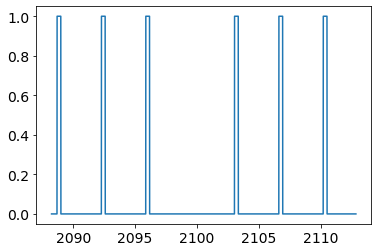

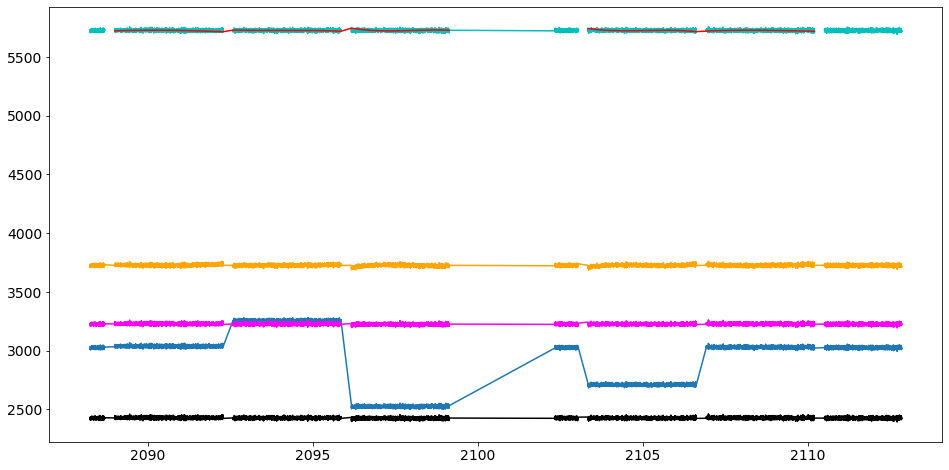

In [9]:
%matplotlib inline
# TIC is unique ID for star
system_tess = exotess[(exotess.TIC == row.TIC)]

# ID is unique, also ignore entries that have no transits
# because there is nothing to mask (they are still searched for flares)
system_kepler = exokepler[(exokepler.hostname == row.ID) &
                   (exokepler.discoverymethod == "Transit")]

try:
    if system_kepler.shape[0] > 0:
        system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                            offset[system_kepler.iloc[0].disc_facility])
    system = pd.concat([system_kepler, system_tess],ignore_index=True)

except KeyError:
    system = system_tess
    print(system.columns)

    
    
# fetch light curve from MAST
flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                download_dir="/home/ekaterina/Documents/001_science/lcs")

# make it a list of LCs even if only one LC is returned
if type(flc) == FlareLightCurve:

    flc = [flc]

elif type(flc) == list:

    flc = flc

# info
mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")

if row.mission == "TESS":
    flc = flc[:1]

# loop over all LCs for the system    
for i, f in enumerate(flc):

    # If any planet transiting
    if system.shape[0] > 0:

        # mask transits
        tranmask = get_full_transit_mask(system, f, pad=0)
        f.flux[tranmask] = np.nan

    # get timestamp for result
    tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
    # apply custom detrending

    try:
        ts = time.clock()
        
        fd = custom_detrending(f)
        tf = time.clock()
        

        # define two hour window for rolling std
        w = np.floor(1. / 12. / np.nanmin(np.diff(fd.time.value)))
        if w%2==0: 
            w+=1

        # use window to estimate the noise in the LC
        df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=2.5)

        fin = np.isfinite(df.detrended_flux.value)
#         print(df.detrended_flux[fin].shape)

                # add results to file
        with open("../results/2020_02_obsdurs.csv", "a") as file:
            s = f"{row.ID},{row.qcs},{i},{df.detrended_flux[fin].shape[0]},{row.mission},2\n"
            file.write(s)    # info

        with open(f"../results/observedtimes/{row.ID}_{row.qcs}_{i}_{row.mission}.csv", "w") as file:
            d = pd.DataFrame({"time":df.time.value[fin],"flux":df.detrended_flux[fin]})
            d.to_csv(file,index=False)
    except Exception as err:
        print("FAIL")
        with open("../results/nodetrend_phase.txt", "a") as file:
            s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
            file.write(s)

# Backlog

In [ ]:
#work through a subset first
# row = fla.iloc[158]
phases = []
trandurs = []
for label, row in fla.iterrows():

    # TIC is unique ID for star
    system_tess = exotess[(exotess.TIC == row.ID)]

    # ID is unique, also ignore entries that have no transits
    # because there is nothing to mask (they are still searched for flares)
    system_kepler = exokepler[(exokepler.hostname == row.ID) &
                       (exokepler.discoverymethod == "Transit")]

    try:
        if system_kepler.shape[0] > 0:
            system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                offset[system_kepler.iloc[0].disc_facility])

        system = pd.concat([system_kepler, system_tess],ignore_index=True)
        system = system.sort_values(by="pl_orbper",ascending=True).iloc[0]

        tmid = system.pl_tranmidepoch
        orbper = system.pl_orbper
        tflare = row.tstart
        phase = ((tflare - tmid) % orbper) / orbper
        trandurs.append(system.pl_trandur / 24. / orbper)
        phases.append(phase)
        print(phase)
    except KeyError:
        phases.append(np.nan)
        trandurs.append(0.)
        print("nope")
    except IndexError:
        phases.append(np.nan)
        trandurs.append(0.)
        print("nope")

In [ ]:
st = startrandurs[~np.isnan(startrandurs)]
np.percentile(np.sort(st),90)

In [ ]:
plt.figure(figsize=(8,5))

hist = plt.hist(phases, bins=np.linspace(0,1,10), histtype="step",edgecolor="r")
plt.axvline(np.nanmean(startrandurs), c="k", label="mean transit duration")
plt.axvline(np.percentile(np.sort(st),95), c="grey", label="95th percentile transit duration")
plt.axvline(np.nanmax(startrandurs), c="silver", label="")
plt.axhline(np.mean(hist[0]),c="orange",label="mean")
plt.fill_between(hist[1],np.mean(hist[0]) - np.std(hist[0]),
                 np.mean(hist[0]) + np.std(hist[0]),alpha=.4,
                 label="standard deviation")
# plt.axhline(np.mean(hist[0]) - np.std(hist[0]))
plt.xlim(0,1)
plt.legend(frameon=False);

In [ ]:
np.std(hist[0])

In [ ]:
fla["phase"] = phases
fla["frac_tran"] = trandurs

In [ ]:
startrandurs = fla.drop_duplicates(subset=["ID"]).frac_tran

In [ ]:
plt.hist(startrandurs, bins=np.logspace(-3,-.5,15), histtype="step", edgecolor="k")
plt.xscale("log")
plt.xlabel("duration of transit / orbital period")
plt.title(f"{len(startrandurs)} star-planet-systems with flares")

In [ ]:
np.sum(startrandurs)/len(startrandurs)

- tranmidepoch is phase 0

- select innermost component in multiplanet systems
- calculate pseudotransit mid epoch for RV planets


- the correct metric is number of flares per observed phase

In [ ]:
0.009200275324758905 * 3000

In [ ]:
system.columns